In [29]:
import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys
import time
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output
from robot import computeRobotData, drawRobotArm, plotRobotDistribution, computeY, computeX, compareInternalPositions, replaceAnglePos, getOriginalAngles, endEffectorDist

""

#tf.enable_eager_execution()
root_logdir = "./tf_logs"

# For output stability across multiple runs of the notebook
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.titlesize"] = 16

print(sys.executable)

def shuffle_batch(X, batch_size):
    # Shuffle the indices
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    # Split the index array into the number of batches
    # Get the list of indexs per batch
    # and yield the values when asked
    for batch_idxs in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idxs]
        yield X_batch

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.__version__

/Users/Work/anaconda3/envs/condaflow/bin/python


'1.13.1'

(20000, 2)
(20000, 2)
(20000, 10)
(20000, 10)
(200, 4, 1)
2
1
0
1
0


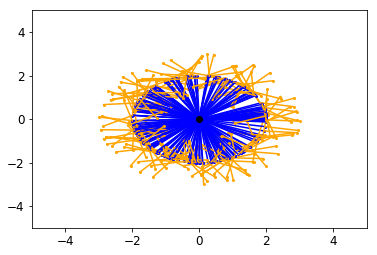

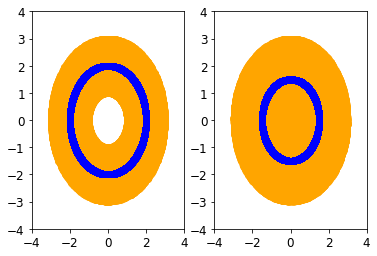

In [2]:
nrLinks1 = 2
lengths1 = [2,1]
nrLinks2 = 2
lengths2 = [1.5,1.5]
nrSamples = 20000
xr1, yr1 = computeRobotData([-np.pi, np.pi], nrLinks1, lengths1, nrSamples)
xr2, yr2 = computeRobotData([-np.pi, np.pi], nrLinks2, lengths2, nrSamples)

#3 links
#nrLinks1 = 3
#lengths1 = [2,1,1]
#nrLinks2 = 3
#lengths2 = [1.5,1.5, 1.5]
#nrSamples = 20000
#xr1, yr1 = computeRobotData([-np.pi, np.pi], nrLinks1, lengths1, nrSamples)
#xr2, yr2 = computeRobotData([-np.pi, np.pi], nrLinks2, lengths2, nrSamples)

r1=np.concatenate([xr1,yr1], axis=1)
r2=np.concatenate([xr2,yr2], axis=1)
print(r1.shape)
print(r2.shape)
drawRobotArm(yr1[:200,:4])
plt.figure()
plt.subplot(1,2,1)
plotRobotDistribution(yr1[:,:nrLinks1*2])
plt.subplot(1,2,2)
plotRobotDistribution(yr2[:,:nrLinks2*2])
train_data = np.concatenate([r1,r2], axis=1)



In [3]:
print(len(yr1[1,:4].shape))
x = np.expand_dims(yr1[1,:4], axis=0)
print(x.shape)

    
sum_diff=0
for i in range(xr1.shape[0]):
    for j in range(nrLinks1):
        a1,a2 = getOriginalAngles(xr1[i,j*2], xr1[i,j*2+1])
        sum_diff += (a1+a2)/2
print(sum_diff/xr1.shape[0])
        

1
(1, 4)
-0.008000970563289826


In [32]:
from model import RoboGAN

reset_graph()

sess = tf.Session()

#nDimX = X1.shape[1]
#nDimY = X2.shape[1]
nDimX = r1.shape[1]
nDimY = r2.shape[1]

GAN = RoboGAN(nDimX, nDimY, endposGenerator = True, conditional_disc= False )

G = GAN.G
D_Y = GAN.D_Y
F = GAN.F
D_X = GAN.D_X

# Getting placeholders
X = GAN.X
Y = GAN.Y

In [33]:
# dummy = tf.placeholder(tf.float32,shape=(100,nDimX))
# config_loss = GAN.valid_config_loss(dummy, nrLinks1, lengths1)
# output = sess.run([config_loss], feed_dict={dummy:r1[:100]})
# output

In [34]:
from train import train_step

losses, gradients, trainers, summary_op = train_step(GAN)

False
True
False
no additional discriminator loss
Discriminator done
Cycle done
end effector generator


In [35]:
# Unpacking losses and gradients from training step output
G_loss, F_loss, D_Y_loss, D_X_loss = losses
G_gradients, F_gradients, D_Y_gradients, D_X_gradients = gradients
train_G, train_F, train_D_Y, train_D_X = trainers

In [36]:
i=1
inputLinks = 2
x=(inputLinks*2)+ (2 * i)+1# :(inputLinks*2) + (2*i) + 1
print(x)

7


## Running the training via a tensorflow session
> Generators will be trained first

In [37]:
sess =  tf.Session()
sess.run(tf.global_variables_initializer())

# Delete exisiting events file
for file in os.listdir(root_logdir):
    os.remove(root_logdir+"/"+file)

train_writer = tf.summary.FileWriter(root_logdir, tf.get_default_graph())

start_time = time.time()
batch_size = 50
nrIterations = 100
n_batches = nrSamples / batch_size
g_losses=[]
d_losses=[]

for epoch in range(nrIterations):
    for batch_index, batch in enumerate(shuffle_batch(train_data, batch_size)):
        X_batch = batch[:,:nDimX]
        Y_batch = batch[:,nDimX:]
        
        # Training Generators G and F first w/ cycle consistency
        Gloss, Floss, _,_ = sess.run([G_loss, F_loss, train_G, train_F],
                                     feed_dict={X:X_batch, Y:Y_batch})
        
        # Optimizing Discriminators D_X and D_Y
        D_Xloss, D_Yloss, _,_, summary = sess.run([D_X_loss, D_Y_loss, train_D_X, train_D_Y, summary_op],
                                         feed_dict={X: X_batch, Y: Y_batch})
        
        step = epoch * n_batches + batch_index 
        if step % 100 == 0:
            train_writer.add_summary(summary, step)
#         train_writer.flush()
    
    print("Epoch {}: GLoss:{:.4f}, FLoss:{:.4f}, DXLoss:{:.4f}, DYLoss:{:.4f}".format(epoch,Gloss,Floss,D_Xloss,D_Yloss))
    g_losses.append([Gloss,Floss])
    d_losses.append([D_Xloss,D_Yloss])
print("Runtime: {:.3f}s".format(time.time()-start_time))
train_writer.close()

Epoch 0: GLoss:4.8023, FLoss:5.0244, DXLoss:0.4928, DYLoss:0.5139
Epoch 1: GLoss:3.0802, FLoss:3.0815, DXLoss:0.4754, DYLoss:0.4940
Epoch 2: GLoss:2.8767, FLoss:2.8332, DXLoss:0.5139, DYLoss:0.4876
Epoch 3: GLoss:2.7141, FLoss:3.0627, DXLoss:0.5836, DYLoss:0.5590
Epoch 4: GLoss:2.4555, FLoss:2.5721, DXLoss:0.6118, DYLoss:0.6298
Epoch 5: GLoss:2.2690, FLoss:2.0858, DXLoss:0.6714, DYLoss:0.6430
Epoch 6: GLoss:2.1435, FLoss:2.1616, DXLoss:0.6737, DYLoss:0.6285
Epoch 7: GLoss:1.9553, FLoss:1.9470, DXLoss:0.6832, DYLoss:0.6821
Epoch 8: GLoss:1.9641, FLoss:2.0011, DXLoss:0.6535, DYLoss:0.6520
Epoch 9: GLoss:1.9036, FLoss:1.8717, DXLoss:0.6801, DYLoss:0.6584
Epoch 10: GLoss:1.8301, FLoss:1.7693, DXLoss:0.7069, DYLoss:0.6925
Epoch 11: GLoss:1.7112, FLoss:1.7389, DXLoss:0.6732, DYLoss:0.6754
Epoch 12: GLoss:1.6895, FLoss:1.6945, DXLoss:0.6598, DYLoss:0.6538
Epoch 13: GLoss:1.6228, FLoss:1.6697, DXLoss:0.6720, DYLoss:0.6619
Epoch 14: GLoss:1.7277, FLoss:1.6564, DXLoss:0.6830, DYLoss:0.6793
Epoch

Text(0.5, 0, 'Iterations')

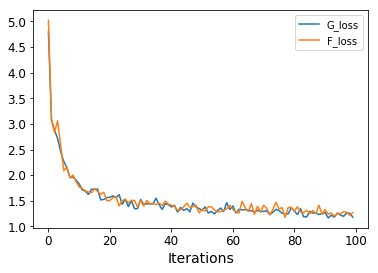

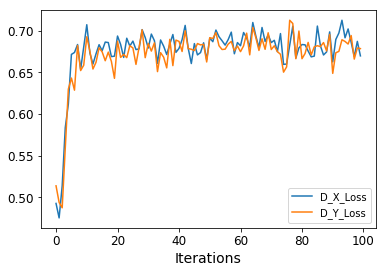

In [38]:

plt.plot(g_losses)
plt.xlabel('Iterations')
plt.legend(['G_loss', 'F_loss'])
plt.figure()
plt.plot(d_losses)
plt.legend(['D_X_Loss', 'D_Y_Loss'])
plt.xlabel('Iterations')

In [39]:
def all_positions_loss(inputData, outputData, maxLength=1):
    inputLinks = round(inputData.shape[1]/5)
    outputLinks = round(outputData.shape[1]/5)

    #ToDo generalize for different numbers of links:
    loss = 0
    for i in range(inputLinks): #inputLinks
        pos1 = inputData[:,(inputLinks*2)+ (2 * i) :(inputLinks*2) + (2*i) + 1]
        pos2 = outputData[:,(outputLinks*2) + (2 * i) : (outputLinks*2 + 2*i) + 1]
        norms = np.linalg.norm(pos1-pos2, axis=1)
        avg = np.mean(norms) #/maxLength
        loss += avg
    loss = loss/inputLinks
    return loss

(20000, 2)
1
0
1
0
Internal positions from angles:
0.14711265743608876
Endeffector distance:
0.15536911114061053
Endeffector distance, positions from angles:
0.24190938532016398


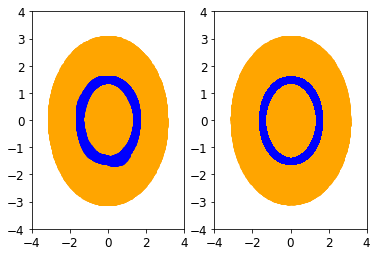

In [40]:
xr1Test, yr1Test = computeRobotData([-np.pi, np.pi], nrLinks1, lengths1, nrSamples)
test_data1 = np.concatenate([xr1Test,yr1Test], axis=1)
#test_data1 = np.concatenate([xr2Test,yr2Test], axis=1)
generated=sess.run([G(X)], feed_dict={X: test_data1})
generated1 = generated[0]


plt.figure()
plt.subplot(1,2,1)
plotRobotDistribution(generated1[:,2*nrLinks1:4*nrLinks1])
plt.subplot(1,2,2)
plotRobotDistribution(yr2[:,:2*nrLinks2])
#plt.figure()
#plotRobotDistribution(yr1[:,:2*nrLinks1])



#forwardPos = positionsFromAngles(generated, nrLinks2, lengths2)
print('Internal positions from angles:')
print(compareInternalPositions(generated1, nrLinks2, lengths2))
print('Endeffector distance:')
print(endEffectorDist(test_data1, generated1, nrLinks1, nrLinks2))
print('Endeffector distance, positions from angles:')
print(endEffectorDist(test_data1, replaceAnglePos(generated1, nrLinks2, lengths2),nrLinks1, nrLinks2))

(20000, 2)
1
0
1
0
Endeffector error pos:
Internal positions from angles:
0.13038646061604264
Endeffector distance:
0.1936585929685689
Endeffector distance, positions from angles:
0.25639702758743615


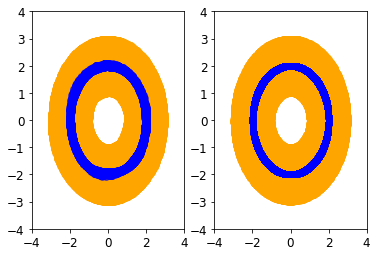

In [41]:
xr2Test, yr2Test = computeRobotData([-np.pi, np.pi], nrLinks2, lengths2, nrSamples)
test_data2 = np.concatenate([xr2Test,yr2Test], axis=1)
#test_data1 = np.concatenate([xr2Test,yr2Test], axis=1)
generated=sess.run([F(X)], feed_dict={X: test_data2[:20000]})
generated2 = generated[0]

plt.figure()
plt.subplot(1,2,1)
plotRobotDistribution(generated2[:,2*nrLinks2:4*nrLinks2])
plt.subplot(1,2,2)
plotRobotDistribution(yr1[:,:2*nrLinks1])

print('Endeffector error pos:')


#forwardPos = positionsFromAngles(generated2, nrLinks2, lengths2)
print('Internal positions from angles:')
print(compareInternalPositions(generated2, nrLinks1, lengths1))
print('Endeffector distance:')
print(endEffectorDist(test_data2, generated2,nrLinks1, nrLinks2))
print('Endeffector distance, positions from angles:')
print(endEffectorDist(test_data2, replaceAnglePos(generated2, nrLinks1, lengths1 ),nrLinks1, nrLinks2))

## Trajectory Evaluation

(10, 4, 2)
2


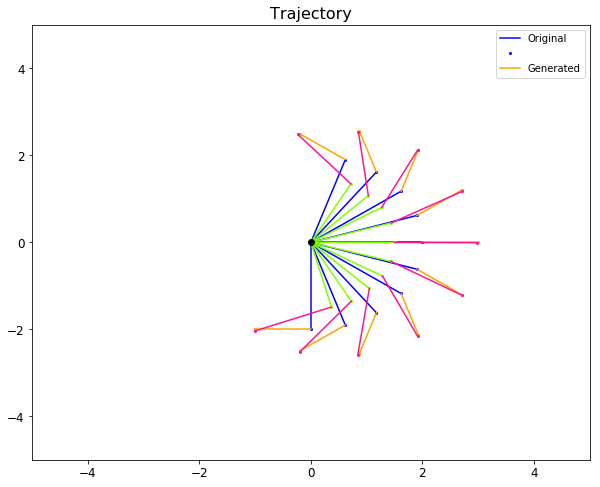

In [44]:
#call with positions (first 2*nrLinks elements of y)
def drawRobotArm(data, showLinks=True):
    if len(data.shape) == 1:
        data = np.expand_dims(data, axis=0)
    if len(data.shape) == 2:
        data = np.expand_dims(data, axis=2)
        
    print(data.shape)
    nrLinks = round(data.shape[1]/2)
#     colors = [['blue', 'orange', 'green', 'darkviolet'], ['dodgerblue', 'goldenrod', 'chartreuse', 'deeppink']]
    colors = [['blue', 'orange', 'green', 'darkviolet'], ['chartreuse', 'deeppink', 'dodgerblue', 'goldenrod']]
    
    print(nrLinks)
    for k in range(data.shape[2]):
        for j in range(data.shape[0]):
            for i in range(nrLinks):
                if i==0:
                    x0=0
                    y0=0

                else:
                    x0=data[j,2*(i-1),k]
                    y0=data[j,2*(i-1)+1,k]
                x1=data[j,2*(i),k]
                y1=data[j,2*(i)+1,k]
                if(showLinks):
                    plt.plot([x0,x1], [y0,y1], color = colors[k][i])
                plt.plot(x1,y1,'o',markersize=2, color = colors[k][i])
    
    plt.legend(("Original", "","Generated"))
    plt.plot(0,0,'o',color='black',linewidth=5)
    plt.xlim([-5,5])
    plt.ylim([-5,5]) 

nrSteps = 10
stepsize = np.pi/nrSteps
trajAngles = np.zeros([nrSteps,nrLinks1])
for i in range(nrSteps):
    for j in range(nrLinks1):
        trajAngles[i,j] = -np.pi/2 + stepsize * i
        

test_traj = np.concatenate([computeX(trajAngles),computeY(trajAngles,lengths1)], axis=1)
generated_traj=sess.run([G(X)], feed_dict={X: test_traj})
generated_traj = generated_traj[0]


plt.figure(figsize=[10,8])
drawRobotArm(np.stack([test_traj[:,2*nrLinks1:4*nrLinks1],generated_traj[:,2*nrLinks2:4*nrLinks2]], axis=2),True)
plt.title("Trajectory")
# plt.legend(("Original", "Generated"))
plt.savefig("uncond_traj.png")

> # Have an evaluation for second robot

In [42]:
print("Joint Loss for Robo1 Generation:")
all_positions_loss(test_data1, generated1)

Joint Loss for Robo1 Generation:


0.3067853198690646

In [43]:
print("Joint Loss for Robo2 Generation:")
all_positions_loss(test_data2, generated2)

Joint Loss for Robo2 Generation:


0.3192738289487098

(1, 4, 1)
2


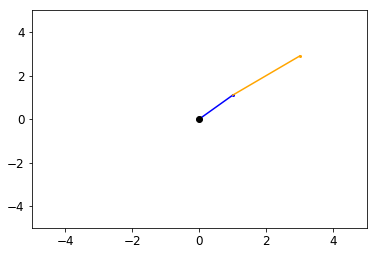

In [17]:
  
    
data = np.matlib.repmat([1.0,1.0,3.0,3.0],10,1) 
for i in range(10):
    data[i,1] = data[i,1] + (1 / 10) * i
    data[i,3] = data[i,3] - (1 / 10) * i
    
data2 = np.matlib.repmat([1.5,1.5,2.5,2.5],10,1) 
for i in range(10):
    data2[i,1] = data2[i,1] + (1 / 10) * i
    data2[i,3] = data2[i,3] - (1 / 10) * i
#print(data)
d = np.stack([data,data2], axis=2)
drawRobotArm(data[1,:], True)


In [18]:
train_writer.get_logdir()

'./tf_logs'

In [19]:
tf.summary

<module 'tensorflow._api.v1.summary' from '/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/_api/v1/summary/__init__.py'>

In [20]:
n_batches

400.0

In [21]:
x=tf.convert_to_tensor([1,2,3])
y=tf.convert_to_tensor([1,1,4])
z=tf.math.greater(x,y)
print(z[0])
a=tf.cond( True, lambda: 4, lambda:5)
print(a)


    

Tensor("strided_slice:0", shape=(), dtype=bool)


TypeError: pred must not be a Python bool

In [ ]:
x = tf.constant([1, 4])
y = tf.constant([2, 5])
z = tf.constant([3, 6])
tf.stack([x, y, z])